## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import string
import re
import time
import torch
import typing

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [4]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
text_1 = ""

for i in text:
    text_1 += i.lower()
    
text_raw = text
text = text_1

In [6]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Preprocessing

max length = 63


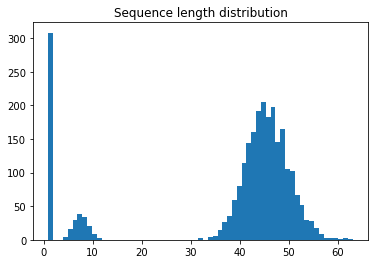

In [8]:
MAX_LENGTH = max(map(len, text_raw))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
hist = plt.hist(list(map(len, text_raw)),bins=MAX_LENGTH)

In [9]:
def replace(sentence, blacklist: str=string.digits+string.punctuation):
      for char in blacklist:
          sentence = sentence.translate({ord(char): None})
      return sentence

def refactor(text, len_thresholds: typing.Tuple[int, int]=(30, MAX_LENGTH), blacklist: str=string.digits+string.punctuation) -> str:
    src_len, res_len = len_thresholds
    return [
        replace(sentence.lstrip().lower(), blacklist)  
        for sentence in text
        if src_len <= len(sentence) <= res_len
    ]

text = refactor(text_raw)

In [10]:
tokens = set("".join(text))

tokens.add('<pad>')

tokens = sorted(list(tokens))
num_tokens = len(tokens)

In [12]:
idx_to_token = dict(list(enumerate(tokens)))
token_to_idx = dict([(token, idx) for idx, token in idx_to_token.items()])

assert len(idx_to_token) == len(token_to_idx)

for i in range(max(len(idx_to_token), len(token_to_idx))):
    assert token_to_idx[idx_to_token[i]] == i

In [13]:
PAD_IDX = token_to_idx['<pad>']

In [14]:
token_to_idx

{'\n': 0,
 ' ': 1,
 '<pad>': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28}

In [15]:
def word_from_tokens(tokens: str) -> np.array:
     return np.array([token_to_idx[token] for token in tokens])

def sentectence_to_tokens(batch: typing.List[str]) -> np.array:
    return np.concatenate(list(map(word_from_tokens, batch)))

In [16]:
def shape_text(text: typing.List[str], max_tokens_len: int):
    joined_text = " ".join(text)
    n_tokens = len(joined_text) // max_tokens_len
    reshaped_text = []
    for i in range(0, n_tokens * max_tokens_len, max_tokens_len):
        reshaped_text.append(joined_text[i:i+max_tokens_len])
    return reshaped_text

In [17]:
def to_matrix(text: typing.List[str], max_len: int=None, pad: int=PAD_IDX, dtype: str='int32', batch_first: bool=True):
    size = max_len or max(map(len, text))
    matrix = np.zeros([len(text), size], dtype) + pad
    for i in range(len(text)):
        line_ix = sentectence_to_tokens([text[i]])
        matrix[i, :len(line_ix)] = line_ix
    if not batch_first:
        matrix = np.transpose(matrix)
    return torch.tensor(matrix, dtype=torch.int64)

In [18]:
from pprint import pprint

pprint(text[:5])
transformed_text = to_matrix(text[:5])
pprint(transformed_text)

['from fairest creatures we desire increase\n',
 'that thereby beautys rose might never die\n',
 'but as the riper should by time decease\n',
 'his tender heir might bear his memory\n',
 'but thou contracted to thine own bright eyes\n']
tensor([[ 8, 20, 17, 15,  1,  8,  3, 11, 20,  7, 21, 22,  1,  5, 20,  7,  3, 22,
         23, 20,  7, 21,  1, 25,  7,  1,  6,  7, 21, 11, 20,  7,  1, 11, 16,  5,
         20,  7,  3, 21,  7,  0,  2,  2,  2],
        [22, 10,  3, 22,  1, 22, 10,  7, 20,  7,  4, 27,  1,  4,  7,  3, 23, 22,
         27, 21,  1, 20, 17, 21,  7,  1, 15, 11,  9, 10, 22,  1, 16,  7, 24,  7,
         20,  1,  6, 11,  7,  0,  2,  2,  2],
        [ 4, 23, 22,  1,  3, 21,  1, 22, 10,  7,  1, 20, 11, 18,  7, 20,  1, 21,
         10, 17, 23, 14,  6,  1,  4, 27,  1, 22, 11, 15,  7,  1,  6,  7,  5,  7,
          3, 21,  7,  0,  2,  2,  2,  2,  2],
        [10, 11, 21,  1, 22,  7, 16,  6,  7, 20,  1, 10,  7, 11, 20,  1, 15, 11,
          9, 10, 22,  1,  4,  7,  3, 20,  1, 10, 11, 21,  

In [19]:
N_EPOCHS = 512

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.


In [20]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [21]:
def plot_loss(losses: list, title: str=None):
    fig = plt.figure(figsize=(15, 10))
    if title is not None:
        plt.title(title)
    plt.plot(losses)
    plt.ylabel('Loss')
    plt.xlabel('Epoch #')
    plt.show()

In [22]:
class VanillaCharRNN(nn.Module):
   
    def __init__(
        self,
        num_tokens: int=len(tokens),
        embedding_size: int=64,
        rnn_num_units: int=128
    ):
        super(VanillaCharRNN, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_num_units, batch_first=True)
        self.linear = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        out, h_next = self.rnn(x_emb, h_prev)
        logits = self.linear(out)
        return h_next, logits
    
    def initial_state(self, batch_size):
        return torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True)


In [24]:
def rnn_epoch(model, hidden_state, all_batches, batch_size):
    global PAD_IDX
    n_batches = all_batches.shape[0] // batch_size
    loss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    epoch_loss = 0.0

    for i in range(0, n_batches * batch_size, batch_size):
        batch_ix = all_batches[i:i+batch_size]
        hidden_state, out = model(batch_ix, hidden_state)
        actual_next_tokens = batch_ix[:, 1:]

        batch_loss = loss(out[:, :-1].reshape(-1, len(tokens)), actual_next_tokens.reshape(-1))
        batch_loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss += batch_loss.item()
        hidden_state.detach_()
        hidden_state = hidden_state.detach()

    epoch_loss /= n_batches
    return hidden_state, epoch_loss

In [25]:
def train(model: nn.Module, n_epochs: int=16, optimizer=None, max_tokens_len: int=MAX_LENGTH-3, batch_size: int=10):
    losses = []
    # Привели к единому размеру
    shaped_text = shape_text(text, max_tokens_len)
    # Перевели в матрицу
    all_batches = to_matrix(shaped_text, max_tokens_len)
    # Поехали
    state = model.initial_state(batch_size)

    for epoch in range(n_epochs):
        print("{}-st epoch of {}".format(epoch + 1, n_epochs))
        state, epoch_loss = rnn_epoch(model, state, all_batches, batch_size)
        losses.append(epoch_loss)

    return losses, state

Plot the loss function (axis X: number of epochs, axis Y: loss function).

1-st epoch of 512
2-st epoch of 512
3-st epoch of 512
4-st epoch of 512
5-st epoch of 512
6-st epoch of 512
7-st epoch of 512
8-st epoch of 512
9-st epoch of 512
10-st epoch of 512
11-st epoch of 512
12-st epoch of 512
13-st epoch of 512
14-st epoch of 512
15-st epoch of 512
16-st epoch of 512
17-st epoch of 512
18-st epoch of 512
19-st epoch of 512
20-st epoch of 512
21-st epoch of 512
22-st epoch of 512
23-st epoch of 512
24-st epoch of 512
25-st epoch of 512
26-st epoch of 512
27-st epoch of 512
28-st epoch of 512
29-st epoch of 512
30-st epoch of 512
31-st epoch of 512
32-st epoch of 512
33-st epoch of 512
34-st epoch of 512
35-st epoch of 512
36-st epoch of 512
37-st epoch of 512
38-st epoch of 512
39-st epoch of 512
40-st epoch of 512
41-st epoch of 512
42-st epoch of 512
43-st epoch of 512
44-st epoch of 512
45-st epoch of 512
46-st epoch of 512
47-st epoch of 512
48-st epoch of 512
49-st epoch of 512
50-st epoch of 512
51-st epoch of 512
52-st epoch of 512
53-st epoch of 512
54

417-st epoch of 512
418-st epoch of 512
419-st epoch of 512
420-st epoch of 512
421-st epoch of 512
422-st epoch of 512
423-st epoch of 512
424-st epoch of 512
425-st epoch of 512
426-st epoch of 512
427-st epoch of 512
428-st epoch of 512
429-st epoch of 512
430-st epoch of 512
431-st epoch of 512
432-st epoch of 512
433-st epoch of 512
434-st epoch of 512
435-st epoch of 512
436-st epoch of 512
437-st epoch of 512
438-st epoch of 512
439-st epoch of 512
440-st epoch of 512
441-st epoch of 512
442-st epoch of 512
443-st epoch of 512
444-st epoch of 512
445-st epoch of 512
446-st epoch of 512
447-st epoch of 512
448-st epoch of 512
449-st epoch of 512
450-st epoch of 512
451-st epoch of 512
452-st epoch of 512
453-st epoch of 512
454-st epoch of 512
455-st epoch of 512
456-st epoch of 512
457-st epoch of 512
458-st epoch of 512
459-st epoch of 512
460-st epoch of 512
461-st epoch of 512
462-st epoch of 512
463-st epoch of 512
464-st epoch of 512
465-st epoch of 512
466-st epoch of 512


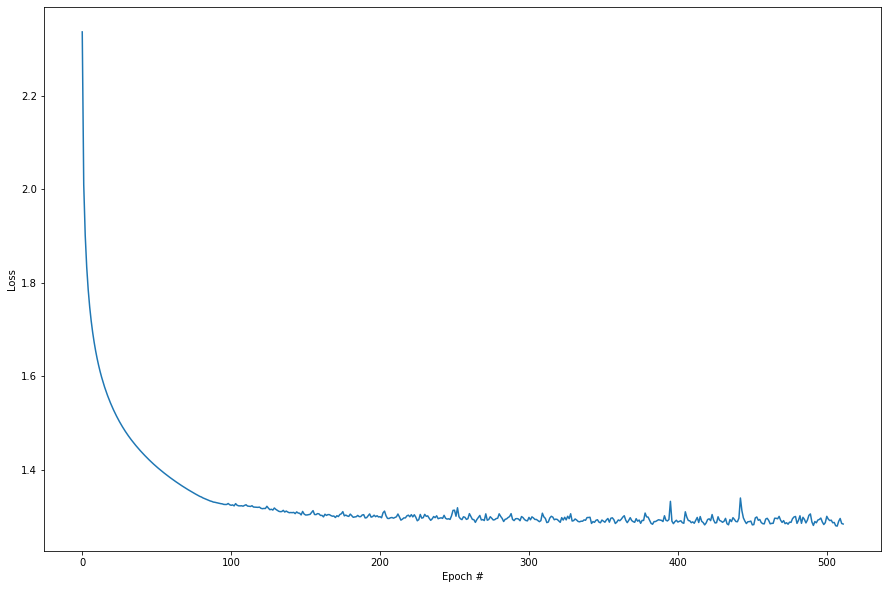

In [26]:
model = VanillaCharRNN()
optimizer = torch.optim.Adam(model.parameters())
vanilla_losses, vanilla_state = train(model, N_EPOCHS, optimizer)
plot_loss(vanilla_losses)

In [28]:
def generate_sample(model, seed_phrase=' ', max_length=400, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.long)
    states = model.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        states, _ = model(x_sequence[:, :, i], states)

    for _ in range(max_length - len(seed_phrase)):
        states, out = model(x_sequence[:,:, -1], states)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0].ravel()
        
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.long)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [29]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"\n\tTemperature: {t}")
    print(generate_sample(model, seed_phrase="not mine", temperature=t))


	Temperature: 0.1
not mine own her show
 the store
 then thou wilt not the world that which i will be the store
 the will be the world doth us the wather say that is not the world may it were i same that i have should my heart that i have should my heart that which in the world with the store
 then the world doth present spendless still the world doth present doth no fair in thee the world doth preser a poor were i

	Temperature: 0.2
not mine own sweet face that i same hast thou thy sweet face not so the world with the store
 then thou wilt not the world doth preser a poor who have even the world doth preser a poor hath heaven on the water and more than thou art which in my love is so shall is show
 the world with the wherein the world doth present doth not to me that the world with the world and there will winds to the water 

	Temperature: 0.5
not mine own tis nor the graced be wood then have no fear hath that your most my self all to hildst that to let me that to return as sweet th

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [34]:
class LSTMCharRNN(nn.Module):

    def __init__(self, num_tokens: int=len(tokens), embedding_size: int=64, rnn_num_units: int=128):
        super(LSTMCharRNN, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embedding_size, rnn_num_units, batch_first=True)
        self.linear = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, states=None):
        x_emb = self.embedding(x)
        if states is None:
            states = initial_state(1)
        out, states = self.lstm(x_emb, states)
        
        logits = self.linear(out)
        return states, logits
    
    def initial_state(self, batch_size) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        return (
            torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True),
            torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True)
        )

In [37]:
def rnn_epoch_lstm(model, states, all_batches, batch_size):
    global PAD_IDX
    n_batches = all_batches.shape[0] // batch_size
    loss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    epoch_loss = 0.0

    for i in range(0, n_batches * batch_size, batch_size):
        batch_ix = all_batches[i:i+batch_size]
        states, out = model(batch_ix, states)
        hidden_state, cell_state = states
        actual_next_tokens = batch_ix[:, 1:]

        batch_loss = loss(out[:, :-1].reshape(-1, len(tokens)), actual_next_tokens.reshape(-1))
        batch_loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += batch_loss.item()

        hidden_state.detach_()
        hidden_state = hidden_state.detach()

        cell_state.detach_()
        cell_state = cell_state.detach()

        states = hidden_state, cell_state
        
    epoch_loss /= n_batches
    return states, epoch_loss

In [38]:
def train_lstm(model: nn.Module, n_epochs: int=16, optimizer=None, max_tokens_len: int=MAX_LENGTH-3, batch_size: int=10):
    losses = []
    # Привели к единому размеру
    shaped_text = shape_text(text, max_tokens_len)
    # Перевели в матрицу
    all_batches = to_matrix(shaped_text, max_tokens_len)
    # Поехали
    state = model.initial_state(batch_size)

    for epoch in range(n_epochs):
        print("{}-st epoch of {}".format(epoch + 1, n_epochs))
        state, epoch_loss = rnn_epoch_lstm(model, state, all_batches, batch_size)
        losses.append(epoch_loss)

    return losses, state

1-st epoch of 512
2-st epoch of 512
3-st epoch of 512
4-st epoch of 512
5-st epoch of 512
6-st epoch of 512
7-st epoch of 512
8-st epoch of 512
9-st epoch of 512
10-st epoch of 512
11-st epoch of 512
12-st epoch of 512
13-st epoch of 512
14-st epoch of 512
15-st epoch of 512
16-st epoch of 512
17-st epoch of 512
18-st epoch of 512
19-st epoch of 512
20-st epoch of 512
21-st epoch of 512
22-st epoch of 512
23-st epoch of 512
24-st epoch of 512
25-st epoch of 512
26-st epoch of 512
27-st epoch of 512
28-st epoch of 512
29-st epoch of 512
30-st epoch of 512
31-st epoch of 512
32-st epoch of 512
33-st epoch of 512
34-st epoch of 512
35-st epoch of 512
36-st epoch of 512
37-st epoch of 512
38-st epoch of 512
39-st epoch of 512
40-st epoch of 512
41-st epoch of 512
42-st epoch of 512
43-st epoch of 512
44-st epoch of 512
45-st epoch of 512
46-st epoch of 512
47-st epoch of 512
48-st epoch of 512
49-st epoch of 512
50-st epoch of 512
51-st epoch of 512
52-st epoch of 512
53-st epoch of 512
54

417-st epoch of 512
418-st epoch of 512
419-st epoch of 512
420-st epoch of 512
421-st epoch of 512
422-st epoch of 512
423-st epoch of 512
424-st epoch of 512
425-st epoch of 512
426-st epoch of 512
427-st epoch of 512
428-st epoch of 512
429-st epoch of 512
430-st epoch of 512
431-st epoch of 512
432-st epoch of 512
433-st epoch of 512
434-st epoch of 512
435-st epoch of 512
436-st epoch of 512
437-st epoch of 512
438-st epoch of 512
439-st epoch of 512
440-st epoch of 512
441-st epoch of 512
442-st epoch of 512
443-st epoch of 512
444-st epoch of 512
445-st epoch of 512
446-st epoch of 512
447-st epoch of 512
448-st epoch of 512
449-st epoch of 512
450-st epoch of 512
451-st epoch of 512
452-st epoch of 512
453-st epoch of 512
454-st epoch of 512
455-st epoch of 512
456-st epoch of 512
457-st epoch of 512
458-st epoch of 512
459-st epoch of 512
460-st epoch of 512
461-st epoch of 512
462-st epoch of 512
463-st epoch of 512
464-st epoch of 512
465-st epoch of 512
466-st epoch of 512


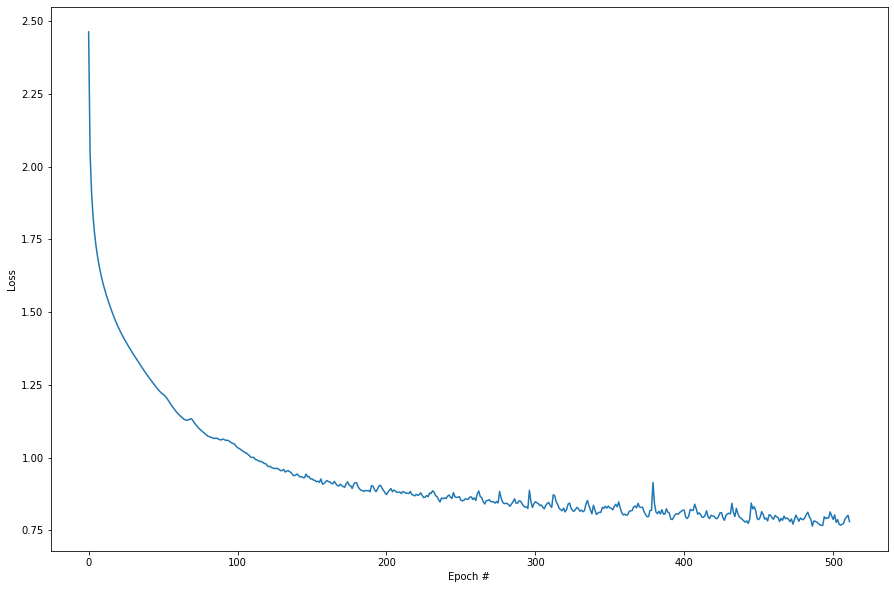

In [39]:
lstm_model = LSTMCharRNN()
optimizer = torch.optim.Adam(lstm_model.parameters())

lstm_losses, lstm_states = train_lstm(lstm_model, N_EPOCHS, optimizer)
plot_loss(lstm_losses)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [41]:
def generate_sample_lstm(model, seed_phrase=' ', max_length=400, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.long)
    states = model.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        states, _ = model(x_sequence[:, :, i], states)

    for _ in range(max_length - len(seed_phrase)):
        states, out = model(x_sequence[:,:, -1], states)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0].ravel()
        
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.long)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [42]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"\n\tTemperature: {t}")
    print(generate_sample_lstm(model, seed_phrase="not mine", temperature=t))


	Temperature: 0.1
not mine own seem that i have should my heart that i am not the proud the world with the world doth preser a poor were in the world that which in the world thou art though my self all my state
 which have and there will gright not to me that that i am not the proud the world doth present seems the proud the world doth uset when the store
 then thou art my praise to me that i have should my love th

	Temperature: 0.2
not mine own have no more so my love to the world may it were i say that is not thee and therefore to me that that i have should my love to the store
 the stor my love to thy part
 thou art that which i say my side
 and therefore the world did in the world that my state
 which every fair where to the store
 thou art find
 the world with the world may ever like and there will gright the world with 

	Temperature: 0.5
not mine own hath the shalt not the praise to methount my love with beauty still with thee
 and praises my self in my love this in fair befor

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [43]:
# Saving and loading code here
torch.save(lstm_model.state_dict(), 'lstm_sonnet.pth')

In [44]:
new_lstm_model = LSTMCharRNN()
new_lstm_model.load_state_dict(torch.load('lstm_sonnet.pth'))
new_lstm_model.eval()

LSTMCharRNN(
  (embedding): Embedding(29, 64, padding_idx=2)
  (lstm): LSTM(64, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=29, bias=True)
)

In [45]:
print(generate_sample(new_lstm_model, max_length=100, temperature=0.75))

 on d will farkinge
 with heaven do mine eye
 to whom forenother white be thy fair if i more thee wa


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)